In [12]:
SEED = 1

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

PATH_SENTENCE_TEXT = r"../dataset/concat_sentence_text.csv"
PATH_SEGMENT_TEXT = r"../dataset/concat_segment_text.csv"

In [ ]:
class GloveVectorizer:
    def __init__(self, verbose=False, lowercase=True, remove_stopwords = True, minchars=3):
        
        # load in pre-trained word vectors
        print('Loading word vectors...')
        word2vec = {}
        embedding = []
        idx2word = []
        with open('../glove/glove.6B/glove.6B.50d.txt', encoding = "utf-8") as f:
              # is just a space-separated text file in the format:
              # word vec[0] vec[1] vec[2] ...
              for line in f:
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
                embedding.append(vec)
                idx2word.append(word)
        print('Found %s word vectors.' % len(word2vec))

        self.word2vec = word2vec
        self.embedding = np.array(embedding)
        self.word2idx = {v:k for k,v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape
        self.verbose = verbose
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.minchars = minchars

    def fit(self, data, *args):
        pass

    def transform(self, data, *args):
        stopwords = list(text.ENGLISH_STOP_WORDS)
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0

        for sentence in data:
            # Note: lower-casing the words
            if self.lowercase & self.remove_stopwords:
                tokens = sentence.lower().split()
                tokens = [word for word in tokens if word not in stopwords]

            else:
                tokens = sentence.split()
                tokens = [word for word in tokens if word not in stopwords]
            vecs = []
            for word in tokens:
                if len(word) >= self.minchars and word in self.word2vec:
                    vec = self.word2vec[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        if self.verbose:
            print("Number of samples with no words found / total: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, X, *args):
        self.fit(X, *args)
        return self.transform(X, *args)

In [ ]:
gv = GloveVectorizer()

In [2]:
df = pd.read_csv(PATH_SEGMENT_TEXT)
df.head()

,segment_text,practice,modality
0,PRIVACY POLICY This privacy policy (hereafter ...,NaN,NaN
1,1. ABOUT OUR PRODUCTS 1.1 Our products offer a...,NaN,NaN
2,2. THE INFORMATION WE COLLECT The information ...,Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
3,2. THE INFORMATION WE COLLECT The information ...,Identifier_IP_Address_1stParty,PERFORMED
4,"2.2 In addition, we store certain information ...",Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED


#### Cut df down to top N practices - probably less noise because not all the counts per practice are equal.

In [3]:
# Save counts into a dataframe
df_value_counts = df["practice"].value_counts().rename_axis("practice").reset_index(name = "counts")
df_value_counts.head(10)

,practice,counts
0,Contact_E_Mail_Address_1stParty,1105
1,Identifier_Cookie_or_similar_Tech_1stParty,858
2,Location_1stParty,821
3,Identifier_IP_Address_1stParty,590
4,Contact_Phone_Number_1stParty,565
5,Identifier_Cookie_or_similar_Tech_3rdParty,524
6,Identifier_Device_ID_1stParty,446
7,Contact_Postal_Address_1stParty,364
8,SSO,274
9,Demographic_Age_1stParty,259


### There are NaNs in the data
Because some segments do not have an associated privacy practice. Filled with "None".

In [4]:
df = df.fillna("None")
df.head()

,segment_text,practice,modality
0,PRIVACY POLICY This privacy policy (hereafter ...,None,None
1,1. ABOUT OUR PRODUCTS 1.1 Our products offer a...,None,None
2,2. THE INFORMATION WE COLLECT The information ...,Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED
3,2. THE INFORMATION WE COLLECT The information ...,Identifier_IP_Address_1stParty,PERFORMED
4,"2.2 In addition, we store certain information ...",Identifier_Cookie_or_similar_Tech_1stParty,PERFORMED


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,4), strip_accents='ascii', binary = True)
tfidf_vectors = vectorizer.fit_transform(df["segment_text"])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df["practice"], test_size = 0.2, random_state = SEED)

## Testing with logistic regression

In [11]:
logistic_clf = LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
y_pred = logistic_clf.predict(x_test)

In [12]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.44      0.73      0.55       199
             Contact_Phone_Number_1stParty       0.30      0.09      0.14       118
Identifier_Cookie_or_similar_Tech_1stParty       0.72      0.78      0.75       169
            Identifier_IP_Address_1stParty       0.54      0.32      0.40       131
                         Location_1stParty       0.56      0.52      0.54       171

                                  accuracy                           0.53       788
                                 macro avg       0.51      0.49      0.48       788
                              weighted avg       0.52      0.53      0.50       788



## Testing with SGDClassifier

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state=SEED, n_jobs = -1).fit(x_train, y_train)
y_pred = clf_sgdclassifier.predict(x_test)

In [15]:
print(classification_report(y_test, y_pred))

                                            precision    recall  f1-score   support

           Contact_E_Mail_Address_1stParty       0.44      0.58      0.50       199
             Contact_Phone_Number_1stParty       0.25      0.19      0.21       118
Identifier_Cookie_or_similar_Tech_1stParty       0.73      0.79      0.76       169
            Identifier_IP_Address_1stParty       0.48      0.32      0.38       131
                         Location_1stParty       0.57      0.57      0.57       171

                                  accuracy                           0.52       788
                                 macro avg       0.50      0.49      0.49       788
                              weighted avg       0.51      0.52      0.51       788



### Testing on top N practices (3 to 10) - same method as sentence level

With tfidf and ngram range from 1 to 4

In [7]:
def testing_top_n() :
    
    results_dict = {"N" : [], "clf" : [], "report" : []}

    for n in range(3, 11) :

        print("Training for " + str(n))
        # iterate through the top n practices
        top_n_practice = list(df_value_counts["practice"][:n])
        df_subset = df[df["practice"].isin(top_n_practice)]
        
        # Vectorize and split training and test sets
        vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,4), strip_accents='ascii', binary = True)
        tfidf_vectors = vectorizer.fit_transform(df_subset["segment_text"])
        x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df_subset["practice"], test_size = 0.2, random_state = SEED)
        
        # Fit classifiers
        print("Fitting logistic...")
        logistic_clf = LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
        y_pred = logistic_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [logistic_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SGDClassifier...")
        clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state=SEED, n_jobs = -1).fit(x_train, y_train)
        y_pred = clf_sgdclassifier.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [clf_sgdclassifier]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SVC...")
        linearSVC_clf = SVC(kernel= "linear", class_weight="balanced").fit(x_train, y_train)
        y_pred = linearSVC_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [linearSVC_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Training done " + str(n))

    return results_dict

In [8]:
results_dict = testing_top_n()

Training for 3
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 3
Training for 4
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 4
Training for 5
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 5
Training for 6
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 6
Training for 7
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 7
Training for 8
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 8
Training for 9
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 9
Training for 10
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 10


In [9]:
# Restructure results so that we can plot across different N numbers
df_results = pd.DataFrame(results_dict)

weighted_avg_dict = {"precision" : [], "recall" : [], "f1" : [], "support" : []}

for row in df_results.itertuples(index = False) :
    weighted_avg_dict["precision"] += [row[2]["weighted avg"]["precision"]]
    weighted_avg_dict["recall"] += [row[2]["weighted avg"]["recall"]]
    weighted_avg_dict["f1"] += [row[2]["weighted avg"]["f1-score"]]
    weighted_avg_dict["support"] += [row[2]["weighted avg"]["support"]]

df_results_weighted_avg = pd.DataFrame(
    {"N" : df_results["N"],
    "classifier" : ["logistic", "sgd_classifier", "svc"] * 8,
    "precision" : weighted_avg_dict["precision"],
    "recall" : weighted_avg_dict["recall"],
    "f1" : weighted_avg_dict["f1"],
    "support" : weighted_avg_dict["support"]}
)

df_results_weighted_avg.head()

,N,classifier,precision,recall,f1,support
0,3,logistic,0.797934,0.795332,0.792923,557
1,3,sgd_classifier,0.797746,0.797127,0.797321,557
2,3,svc,0.802743,0.800718,0.801536,557
3,4,logistic,0.648615,0.662222,0.647635,675
4,4,sgd_classifier,0.653262,0.665185,0.657215,675


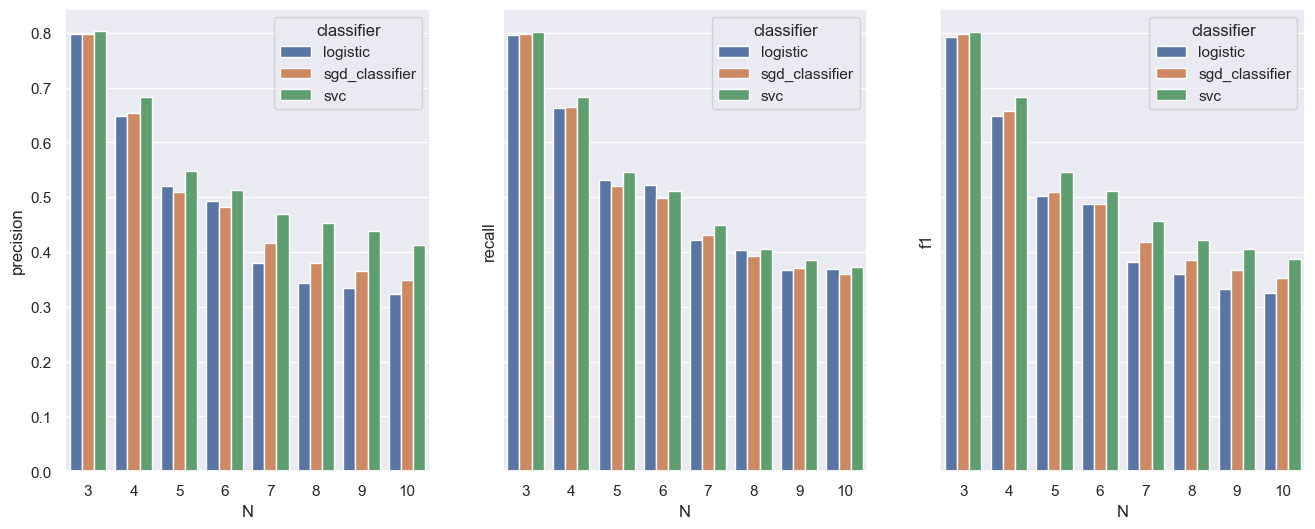

In [11]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
sns.set(rc={'figure.figsize':(16,6)})

sns.barplot(data = df_results_weighted_avg, x = "N", y = "precision", hue = "classifier", ax = ax[0])
sns.barplot(data = df_results_weighted_avg, x = "N", y = "recall", hue = "classifier", ax = ax[1])
sns.barplot(data = df_results_weighted_avg, x = "N", y = "f1", hue = "classifier", ax=ax[2])

plt.show()

### With Glove embeddings

In [8]:
def testing_top_n_glove() :
    
    results_dict = {"N" : [], "clf" : [], "report" : []}

    for n in range(3, 11) :

        print("Training for " + str(n))
        # iterate through the top n practices
        top_n_practice = list(df_value_counts["practice"][:n])
        df_subset = df[df["practice"].isin(top_n_practice)]
        
        # Vectorize and split training and test sets
        vectorizer = gv
        tfidf_vectors = vectorizer.fit_transform(df_subset["segment_text"])
        x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, df_subset["practice"], test_size = 0.2, random_state = SEED)
        
        # Fit classifiers
        print("Fitting logistic...")
        logistic_clf = LogisticRegression(random_state = SEED, max_iter = 500, n_jobs = -1, multi_class = "ovr").fit(x_train, y_train)
        y_pred = logistic_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [logistic_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SGDClassifier...")
        clf_sgdclassifier = SGDClassifier(loss = "hinge", max_iter = 5000, random_state=SEED, n_jobs = -1).fit(x_train, y_train)
        y_pred = clf_sgdclassifier.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [clf_sgdclassifier]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Fitting SVC...")
        linearSVC_clf = SVC(kernel= "linear", class_weight="balanced").fit(x_train, y_train)
        y_pred = linearSVC_clf.predict(x_test)
        results_dict["N"] += [n]
        results_dict["clf"] += [linearSVC_clf]
        results_dict["report"] += [classification_report(y_test, y_pred, output_dict=True)]

        print("Training done " + str(n))

    return results_dict

In [11]:
results_dict = testing_top_n_glove()

Training for 3
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 3
Training for 4
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 4
Training for 5
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 5
Training for 6
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 6
Training for 7
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 7
Training for 8
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...


c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tristan\anaconda3\envs\interpret_gpu\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Training done 8
Training for 9
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 9
Training for 10
Fitting logistic...
Fitting SGDClassifier...
Fitting SVC...
Training done 10


In [13]:
# Restructure results so that we can plot across different N numbers
df_results_glove = pd.DataFrame(results_dict)

weighted_avg_dict = {"precision" : [], "recall" : [], "f1" : [], "support" : []}

for row in df_results_glove.itertuples(index = False) :
    weighted_avg_dict["precision"] += [row[2]["weighted avg"]["precision"]]
    weighted_avg_dict["recall"] += [row[2]["weighted avg"]["recall"]]
    weighted_avg_dict["f1"] += [row[2]["weighted avg"]["f1-score"]]
    weighted_avg_dict["support"] += [row[2]["weighted avg"]["support"]]

df_results_glove_weighted_avg = pd.DataFrame(
    {"N" : df_results_glove["N"],
    "clf" : ["logistic", "sgd_classifier", "svc"] * 8,
    "precision" : weighted_avg_dict["precision"],
    "recall" : weighted_avg_dict["recall"],
    "f1" : weighted_avg_dict["f1"],
    "support" : weighted_avg_dict["support"]}
)

df_results_glove_weighted_avg.head()

,N,clf,precision,recall,f1,support
0,3,logistic,0.778871,0.779174,0.777766,557
1,3,sgd_classifier,0.773886,0.773788,0.773127,557
2,3,svc,0.776175,0.771993,0.773378,557
3,4,logistic,0.649279,0.665185,0.651496,675
4,4,sgd_classifier,0.649447,0.645926,0.639061,675


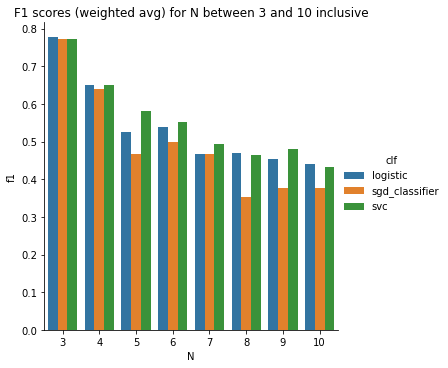

In [14]:
g = sns.catplot(data = df_results_glove_weighted_avg, kind = "bar", x = "N", y = "f1", hue = "clf").set(title = "F1 scores (weighted avg) for N between 3 and 10 inclusive")

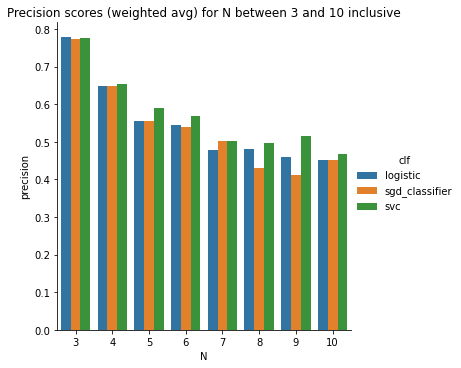

In [15]:
g = sns.catplot(data = df_results_glove_weighted_avg, kind = "bar", x = "N", y = "precision", hue = "clf").set(title = "Precision scores (weighted avg) for N between 3 and 10 inclusive")

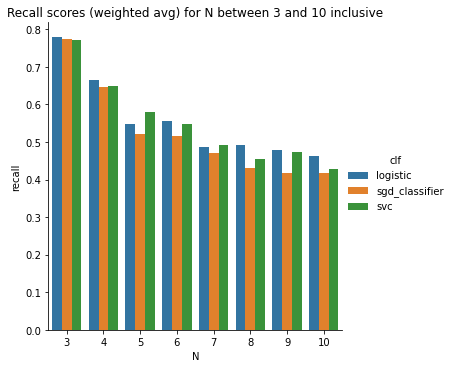

In [16]:
g = sns.catplot(data = df_results_glove_weighted_avg, kind = "bar", x = "N", y = "recall", hue = "clf").set(title = "Recall scores (weighted avg) for N between 3 and 10 inclusive")